# Read the dataset file “labels.csv”
visualizing the data

In [1]:
%matplotlib inline
from os.path import join
import pandas as pd

# relative path
DATA_FILES_PATH = '../Dog-Breed-Classifier/testData/'

# loading labels.csv
INTRO_DF = pd.read_csv(join(DATA_FILES_PATH, 'labels.csv'))

# describe the dataset
INTRO_DF.head(10)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier
7,002a283a315af96eaea0e28e7163b21b,borzoi
8,003df8b8a8b05244b1d920bb6cf451f9,basenji
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound


# Breed image distribution

In [2]:
INTRO_DF.pivot_table(index='breed',aggfunc=len).sort_values('id',ascending=True).describe()

,id
count,120.000000
mean,85.183333
std,13.298122
min,66.000000
25%,75.000000
50%,82.000000
75%,91.250000
max,126.000000


#### Scottish_deerhound being the largest
#### Briard being the smallest

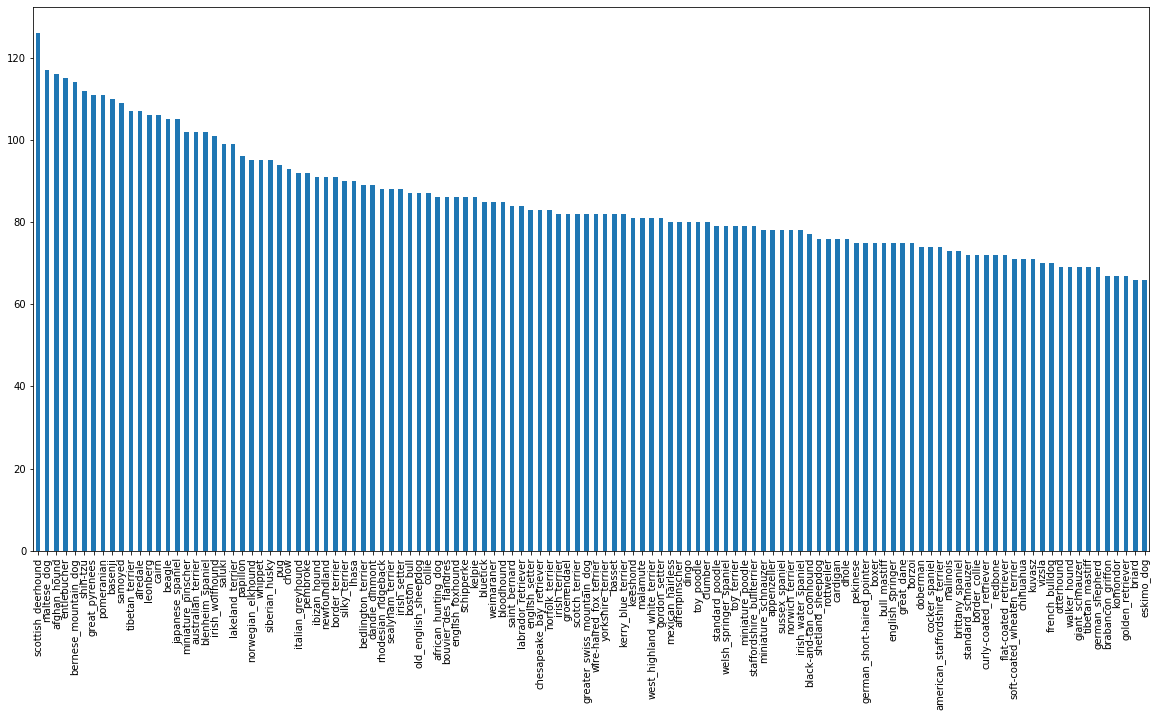

In [3]:
# we can choose from 2 option views

# opition 1
# ax=pd.value_counts(INTRO_DF['breed'],ascending=True).plot(kind='barh',
#                                                        fontsize="40",
#                                                        title=" Dog Distribution",
#                                                        figsize=(50,100))
# ax.set(xlabel="Images per class", ylabel="Classes")
# ax.xaxis.label.set_size(40)
# ax.yaxis.label.set_size(40)
# ax.title.set_size(60)

# opition 2
INTRO_DF["breed"].value_counts().plot.bar(figsize=(20, 10))


In [4]:
uniqueBreeds = INTRO_DF.breed.unique()
dictBreed = dict(zip(uniqueBreeds,range(len(uniqueBreeds))))
INTRO_DF['breedNum'] = INTRO_DF['breed'].map(dictBreed)
INTRO_DF[:10]

,id,breed,breedNum
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1
2,001cdf01b096e06d78e9e5112d419397,pekinese,2
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,3
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,4
5,002211c81b498ef88e1b40b9abf84e1d,bedlington_terrier,5
6,00290d3e1fdd27226ba27a8ce248ce85,bedlington_terrier,5
7,002a283a315af96eaea0e28e7163b21b,borzoi,6
8,003df8b8a8b05244b1d920bb6cf451f9,basenji,7
9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound,8


In [5]:
from sklearn.model_selection import train_test_split
from glob import glob
import re

TRAIN_PATH = (join(DATA_FILES_PATH, 'train/*'))

arr_paths = glob(TRAIN_PATH)
labels = []
for ids in arr_paths:
    ids = re.split(r'(\\|/)',ids)[-1].split(".")[0]
    breed_name = list(INTRO_DF[INTRO_DF.id == ids]["breed"])[0]
    breed_ids = dictBreed[breed_name]
    labels.append(breed_ids)

# ids = ids[:1000]
# labels = labels[:1000]
print(labels[:10])

[38, 116, 45, 4, 69, 35, 104, 77, 113, 46]


### Testing

In [6]:
labels_dict = {i:j for i,j in zip(INTRO_DF['id'],INTRO_DF['breed'])}
classes = set(labels_dict.values())
images = [f for f in os.listdir(DATA_FILES_PATH+'train')]

In [7]:
# if  not os.path.exists('training_images'):
#         os.makedirs('training_images')

# if  not os.path.exists('validation_images'):
#     os.makedirs('validation_images')


In [8]:
# os.chdir('training_images')
# for curClass in classes:    
#     if  not os.path.exists(curClass):
#         os.makedirs(curClass)
#         #os.rmdir(curClass)

# os.chdir('../validation_images')
# for curClass in classes:    
#     if  not os.path.exists(curClass):
#         os.makedirs(curClass)

In [9]:
# from shutil import copyfile
# os.chdir('..')
# count = 0 
# destination_directory = 'training_images/'
# for item in images:
#     if count >7999:
#         destination_directory = 'validation_images/'
#     filekey = os.path.splitext(item)[0]
#     if  not os.path.exists(destination_directory+labels_dict[filekey]+'/'+item):
#         copyfile(DATA_FILES_PATH+'train/'+item, destination_directory+labels_dict[filekey]+'/'+item)
#     print(labels_dict[filekey])
#     count +=1

Using TensorFlow backend.


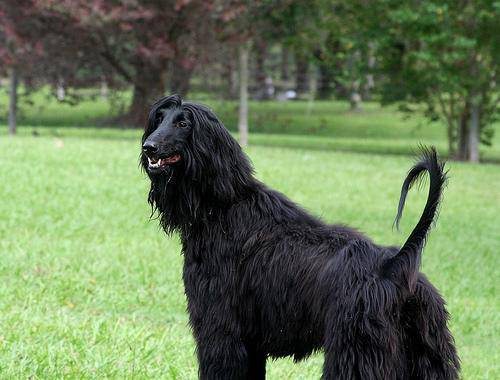

In [10]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

img = load_img(join(DATA_FILES_PATH, 'train', '0d5a88f0ab2db8d34b533c69768135e8.jpg')) 
img

In [11]:

# datagen = ImageDataGenerator(
#         rotation_range=50,
#         width_shift_range=0.3,
#         height_shift_range=0.2,
#         shear_range=0.3,
#         zoom_range=0.3,
#         horizontal_flip=True,
#         fill_mode='nearest')
 
# x = img_to_array(img)
# x = x.reshape((1,) + x.shape)

# i = 0
# for batch in datagen.flow(x, batch_size=1,
#                           save_to_dir='preview', save_prefix='dog_breed', save_format='jpeg'):
#     i += 1
#     if i > 20:
#         break  # otherwise the generator would loop indefinitely

In [12]:
img_preview_path = '../Dog-Breed-Classifier/'
img1=load_img(join(img_preview_path,'preview/dog_breed_0_1004.jpeg'))
img1

FileNotFoundError: [Errno 2] No such file or directory: '../Dog-Breed-Classifier/preview/dog_breed_0_292.jpeg'

In [13]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Conv2D,Dropout
from keras.preprocessing.image import ImageDataGenerator

In [14]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)
#check class_mode in keras documentation https://keras.io/preprocessing/image/
training_set = train_datagen.flow_from_directory(
        'training_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'validation_images',
        target_size=(128, 128),
        batch_size=20,
        class_mode='categorical')

Found 9738 images belonging to 120 classes.
Found 3960 images belonging to 120 classes.


In [15]:
clf = Sequential()
#Convolution
#32 is number of kernals of 3x3, we can use 64 128 256 etc in next layers
#input shape can be 128, 256 later
clf.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))
#Max Pooling size reduces divided by 2
clf.add(MaxPooling2D(pool_size=(2,2)))      


#clf.add(Dropout(0.5))

clf.add(Conv2D(32,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.25))

clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
#clf.add(Dropout(0.10))
#Flattening
clf.add(Flatten())
        
#Adding An ANN
#lets take 128 hidden nodes in hidden layer
#clf.add(Dense(units=128,activation='relu'))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units=120,activation='softmax'))
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping
early_stopping_monitor=EarlyStopping(patience=6)

In [13]:

hist=clf.fit_generator(
        training_set,
        steps_per_epoch=400,
        epochs=50,
        validation_data=test_set,
        validation_steps=2222,
callbacks=[early_stopping_monitor])

Epoch 1/50
399/400 [============================>.] - ETA: 0s - loss: 4.7876 - accuracy: 0.0100

KeyboardInterrupt: 

In [ ]:
clf = Sequential()
#Convolution
#32 is number of kernals of 3x3, we can use 64 128 256 etc in next layers
#input shape can be 128, 256 later
clf.add(Conv2D(32,(3,3),input_shape=(128,128,3),activation='relu'))
#Max Pooling size reduces divided by 2
clf.add(MaxPooling2D(pool_size=(2,2)))      


#clf.add(Dropout(0.5))

clf.add(Conv2D(32,(3,3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2,2)))
#clf.add(Dropout(0.25))

clf.add(Conv2D(64, (3, 3), activation='relu'))
clf.add(MaxPooling2D(pool_size=(2, 2)))
#clf.add(Dropout(0.10))
#Flattening
clf.add(Flatten())
        
#Adding An ANN
#lets take 128 hidden nodes in hidden layer
#clf.add(Dense(units=128,activation='relu'))
clf.add(Dense(units=64, activation='relu'))
clf.add(Dropout(0.5))
clf.add(Dense(units=120,activation='softmax'))
#stochastic gradient descent -Adam -optimizer
#loss func categorical cross entropy
#metrics = accuracy
clf.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
from keras.callbacks import EarlyStopping
early_stopping_monitor=EarlyStopping(patience=6)

In [17]:

hist=clf.fit_generator(
        training_set,
        steps_per_epoch=400,
        epochs=50,
        validation_data=test_set,
        validation_steps=2222,
callbacks=[early_stopping_monitor])

Epoch 1/50
400/400 [==============================] - 505s 1s/step - loss: 4.7890 - accuracy: 0.0078 - val_loss: 4.7863 - val_accuracy: 0.0107
Epoch 2/50
400/400 [==============================] - 509s 1s/step - loss: 4.7836 - accuracy: 0.0121 - val_loss: 4.7562 - val_accuracy: 0.0108
Epoch 3/50
400/400 [==============================] - 444s 1s/step - loss: 4.7799 - accuracy: 0.0101 - val_loss: 4.8018 - val_accuracy: 0.0171
Epoch 4/50
400/400 [==============================] - 463s 1s/step - loss: 4.7793 - accuracy: 0.0099 - val_loss: 4.7437 - val_accuracy: 0.0125
Epoch 5/50
400/400 [==============================] - 478s 1s/step - loss: 4.7627 - accuracy: 0.0154 - val_loss: 4.5895 - val_accuracy: 0.0223
Epoch 6/50
400/400 [==============================] - 471s 1s/step - loss: 4.7115 - accuracy: 0.0175 - val_loss: 4.5790 - val_accuracy: 0.0208
Epoch 7/50
400/400 [==============================] - 470s 1s/step - loss: 4.6441 - accuracy: 0.0199 - val_loss: 4.3951 - val_accuracy: 0.0283

KeyboardInterrupt: 